In [ ]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.4.0+cu121


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch==2.4.0

In [ ]:
# Install torch geometric
if 'IS_GRADESCOPE_ENV' not in os.environ:
  torch_version = str(torch.__version__)
  scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  !pip install torch-scatter -f $scatter_src
  !pip install torch-sparse -f $sparse_src
  !pip install torch-geometric
  !pip install ogb

Looking in links: https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 17.6 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.0 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(8,8))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print(dataset)

Processing...
Done!


Cora()


In [ ]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
# x = [2708, 1433]  --> 2708 nodes and each node has 1433 dimension feature associated with it
# edge_index=[2, 10556] --> Edge list i.e., connectivity between nodes
# y=[2708] --> one label per node
# train_mask=[2708], val_mask=[2708], test_mask=[2708]) --> Boolean tensor indicating which split the node belongs to

In [ ]:
print(f'No of Graphs:{len(dataset)}')
print(f'No of Features:{dataset.num_features}')
print(f'No of Classes:{dataset.num_classes}')

No of Graphs:1
No of Features:1433
No of Classes:7


In [ ]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()
    self.conv1 = GCNConv(dataset.num_features, hidden_dim)
    #self.bn = torch.nn.BatchNorm1d(hidden_dim)
    #self.conv2 = GCNConv(hidden_dim, hidden_dim)
    self.conv3 = GCNConv(hidden_dim, dataset.num_classes)

  def forward(self, x, edge_list):
    x = self.conv1(x, edge_list)
    x = F.relu(x)
    x = F.dropout(x, p=0.15, training=self.training)
    x = self.conv3(x,edge_list)
    return x

In [ ]:
model = GCN(hidden_dim=16)
model.eval()


GCN(
  (conv1): GCNConv(1433, 16)
  (conv3): GCNConv(16, 7)
)

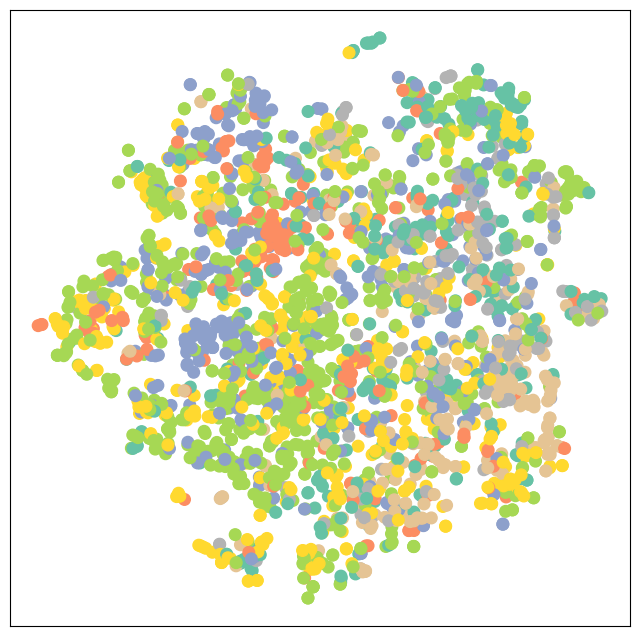

In [ ]:
model.eval()

x = model(data.x, data.edge_index)
visualize(x, color=data.y)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05, weight_decay=25e-5)
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
def train():
  model.train()
  optimizer.zero_grad()
  output = model(data.x, data.edge_index)
  #print(output)
  loss =  criterion(output[data.train_mask], data.y[data.train_mask])

  loss.backward()
  optimizer.step()

  return loss


In [ ]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      #print(pred)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

In [ ]:
for i in range(100):
    l = train()
    print(f'Epoch: {i:03d}, Loss: {l:.4f}')

Epoch: 000, Loss: 0.0960
Epoch: 001, Loss: 0.2154
Epoch: 002, Loss: 0.1011
Epoch: 003, Loss: 0.1475
Epoch: 004, Loss: 0.1354
Epoch: 005, Loss: 0.1037
Epoch: 006, Loss: 0.0963
Epoch: 007, Loss: 0.0830
Epoch: 008, Loss: 0.0749
Epoch: 009, Loss: 0.0757
Epoch: 010, Loss: 0.1033
Epoch: 011, Loss: 0.0847
Epoch: 012, Loss: 0.0849
Epoch: 013, Loss: 0.0748
Epoch: 014, Loss: 0.0817
Epoch: 015, Loss: 0.0842
Epoch: 016, Loss: 0.0891
Epoch: 017, Loss: 0.0909
Epoch: 018, Loss: 0.0771
Epoch: 019, Loss: 0.0855
Epoch: 020, Loss: 0.0853
Epoch: 021, Loss: 0.0899
Epoch: 022, Loss: 0.0996
Epoch: 023, Loss: 0.0899
Epoch: 024, Loss: 0.0854
Epoch: 025, Loss: 0.0800
Epoch: 026, Loss: 0.0852
Epoch: 027, Loss: 0.0845
Epoch: 028, Loss: 0.0815
Epoch: 029, Loss: 0.0809
Epoch: 030, Loss: 0.0783
Epoch: 031, Loss: 0.0660
Epoch: 032, Loss: 0.0850
Epoch: 033, Loss: 0.0768
Epoch: 034, Loss: 0.0906
Epoch: 035, Loss: 0.0770
Epoch: 036, Loss: 0.0903
Epoch: 037, Loss: 0.0819
Epoch: 038, Loss: 0.0959
Epoch: 039, Loss: 0.0884


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8050


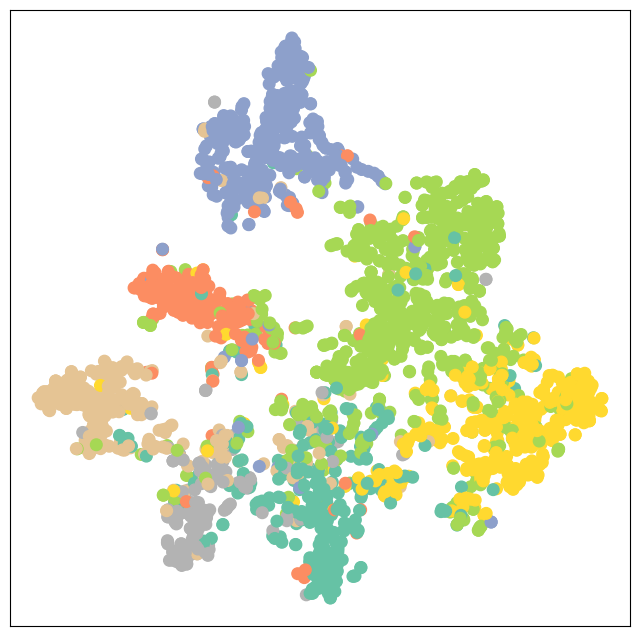

In [ ]:
model.eval()

output = model(data.x, data.edge_index)
visualize(output, color=data.y)